https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

In [1]:
#!pip install mecab-python3
#!pip install unidic-lite
#!pip install --no-binary :all: mecab-python3
#!pip install torchtext==0.6.0
#!python -m spacy download ja_core_news_sm
#!python -m spacy download en_core_web_sm
#!python -m spacy link en_core_web_sm en
#!python -m spacy link ja_core_news_sm ja
#!pip install datasets


conda create -n rapids-24.06 -c rapidsai -c conda-forge -c nvidia  \
    rapids=24.06 python=3.11 'cuda-version>=12.0,<=12.2' \
    dask-sql jupyterlab dash graphistry tensorflow xarray-spatial 'pytorch=*=*cuda*'

load on server

#### steps to take to start server
 * step 1 open Ubuntu
 * steps 2 run conda init
 * step 3 run conda activate rapids-24.06
 * step 4 run jupyter notebook
 * step 5 (maybe?) run pip install jupyter

In [2]:
%load_ext cudf.pandas
import cudf.pandas
#cudf.pandas.install()
import pandas as pd

In [3]:
%reload_ext cudf.pandas
import cudf.pandas


In [4]:
import gc
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from numpy.random import shuffle
#from keras import preprocessing
import tensorflow as tf
from keras.utils import to_categorical
Tokenizer = tf.keras.preprocessing.text.Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.utils import plot_model

from keras.layers import Input, Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from keras.models import Sequential
#from keras.callbacks import ModelCheckpoint

from pickle import dump
from unicodedata import normalize
import cudf


/tmp/ipykernel_424110/3015446719.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

2024-08-19 14:31:58.987351: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 14:31:59.018603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 14:31:59.018637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 14:31:59.020078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 14:31:59.026053: I tensorflow/core/platform/cpu_feature_gua

## load dataset

In [5]:
df=cudf.read_csv("senior project/train")
needtorow=df.columns[0]
df=df.rename(columns={needtorow:'text'})
df

,text
0,nothing thrills me more than to see kids polli...
1,do you want to spend all night at the cemetery...
2,our ships are in attack position.\t船はもう攻撃発起位置にある。
3,what about the original sam? huh?\tオリジナルの サムが居...
4,even though
...,...
2785853,what good would that have done?\t知って何の意味がある?
2785854,when ichinosukesan rushed over to ninosukesan....
2785855,your words are so encouraging.\tそういった お言葉を力に...。
2785856,goodbye


In [6]:
df=df.dropna()
df[["eng","jpn"]]=df['text'].str.split('\t',n=1, expand=True)
df=df.drop(['text'], axis=1)
df=df.dropna()
df=df.reset_index(drop=True)
df

,eng,jpn
0,nothing thrills me more than to see kids polli...,生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!
1,do you want to spend all night at the cemetery...,この雨の中 一晩中 墓地にいたい?
2,our ships are in attack position.,船はもう攻撃発起位置にある。
3,what about the original sam? huh?,オリジナルの サムが居るんだぞ
4,we will now begin the emergency captains' meet...,これより 緊急隊首会を行う。
...,...,...
2007888,that citizens and city governments around the ...,知る必要のある
2007889,what good would that have done?,知って何の意味がある?
2007890,when ichinosukesan rushed over to ninosukesan..,二之助さんに駆け寄った 一之助さんは
2007891,your words are so encouraging.,そういった お言葉を力に...。


## cleaning data

In [7]:
import numpy as np
import re
english_column = []
for i in df['eng'].values_host:
    i=i.replace("?"," questionmark ").lower()
    i=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.", " ", i)
    i=i.replace(" t "," not ")
    i=i.replace(" ll "," will ")
    i=i.replace(" d "," had ")
    i=i.replace(" m "," am ")
    i=i.replace(" ve "," have ")
    i=i.replace(" s "," is ")
    i=i.replace(" re "," have ")
    i=i.replace("  "," ")
    i='<sos>'+i
    english_column.append(i)
japanese_column=[]
for i in df['jpn'].values_host:
    list_of_syntax=["。",".","!","(",")","・","“"]
    i=i.replace("?","questionmark")
    for j in list_of_syntax:
        i=i.replace(j,"")
     
    i='<sos>'+i
    japanese_column.append(i)    
df['eng']=english_column
df['jpn']=japanese_column
df

,eng,jpn
0,<sos>nothing thrills me more than to see kids ...,<sos>生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ
1,<sos>do you want to spend all night at the cem...,<sos>この雨の中 一晩中 墓地にいたいquestionmark
2,<sos>our ships are in attack position,<sos>船はもう攻撃発起位置にある
3,<sos>what about the original sam questionmark ...,<sos>オリジナルの サムが居るんだぞ
4,<sos>we will now begin the emergency captains ...,<sos>これより 緊急隊首会を行う
...,...,...
2007888,<sos>that citizens and city governments around...,<sos>知る必要のある
2007889,<sos>what good would that have done questionmark,<sos>知って何の意味があるquestionmark
2007890,<sos>when ichinosukesan rushed over to ninosuk...,<sos>二之助さんに駆け寄った 一之助さんは
2007891,<sos>your words are so encouraging,<sos>そういった お言葉を力に


In [8]:
import MeCab

def jpnsplit(str,wakati):
    return wakati.parse(str).split()


In [9]:
jpn_space_sentence=[]
wakati = MeCab.Tagger("-Owakati")

for i in df['jpn'].to_pandas():
    jpn_space_sentence.append(jpnsplit(i,wakati))
df['jpn']=jpn_space_sentence
df

,eng,jpn
0,<sos>nothing thrills me more than to see kids ...,"[<, sos, >, 生徒, が, お, 互い, の, 受精, じゃ, なく, て, 植物..."
1,<sos>do you want to spend all night at the cem...,"[<, sos, >, この, 雨, の, 中, 一, 晩, 中, 墓地, に, い, たい..."
2,<sos>our ships are in attack position,"[<, sos, >, 船, は, もう, 攻撃, 発起, 位置, に, ある]"
3,<sos>what about the original sam questionmark ...,"[<, sos, >, オリジナル, の, サム, が, 居る, ん, だ, ぞ]"
4,<sos>we will now begin the emergency captains ...,"[<, sos, >, これ, より, 緊急, 隊, 首, 会, を, 行う]"
...,...,...
2007888,<sos>that citizens and city governments around...,"[<, sos, >, 知る, 必要, の, ある]"
2007889,<sos>what good would that have done questionmark,"[<, sos, >, 知っ, て, 何, の, 意味, が, ある, questionmark]"
2007890,<sos>when ichinosukesan rushed over to ninosuk...,"[<, sos, >, 二, 之, 助, さん, に, 駆け寄っ, た, 一之助, さん, は]"
2007891,<sos>your words are so encouraging,"[<, sos, >, そう, いっ, た, お, 言葉, を, 力, に]"


In [10]:
eng_space_sentence=[]

for i in df['eng'].to_pandas():
    eng_space_sentence.append(i.split())
df['eng']=eng_space_sentence
df

,eng,jpn
0,"[<sos>nothing, thrills, me, more, than, to, se...","[<, sos, >, 生徒, が, お, 互い, の, 受精, じゃ, なく, て, 植物..."
1,"[<sos>do, you, want, to, spend, all, night, at...","[<, sos, >, この, 雨, の, 中, 一, 晩, 中, 墓地, に, い, たい..."
2,"[<sos>our, ships, are, in, attack, position]","[<, sos, >, 船, は, もう, 攻撃, 発起, 位置, に, ある]"
3,"[<sos>what, about, the, original, sam, questio...","[<, sos, >, オリジナル, の, サム, が, 居る, ん, だ, ぞ]"
4,"[<sos>we, will, now, begin, the, emergency, ca...","[<, sos, >, これ, より, 緊急, 隊, 首, 会, を, 行う]"
...,...,...
2007888,"[<sos>that, citizens, and, city, governments, ...","[<, sos, >, 知る, 必要, の, ある]"
2007889,"[<sos>what, good, would, that, have, done, que...","[<, sos, >, 知っ, て, 何, の, 意味, が, ある, questionmark]"
2007890,"[<sos>when, ichinosukesan, rushed, over, to, n...","[<, sos, >, 二, 之, 助, さん, に, 駆け寄っ, た, 一之助, さん, は]"
2007891,"[<sos>your, words, are, so, encouraging]","[<, sos, >, そう, いっ, た, お, 言葉, を, 力, に]"


### another attempt

* conda install -c conda-forge spacy
* conda install -c conda-forge cupy
* python -m spacy download en_core_web_trf
* python -m spacy download ja_core_news_trf

## removing outleirs

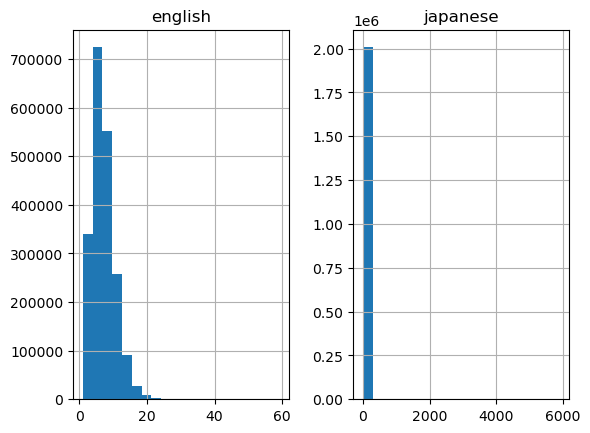

,english,japanese
0,14,22
1,14,15
2,6,11
3,8,11
4,8,11
...,...,...
2007888,8,7
2007889,7,11
2007890,6,13
2007891,5,11


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
eng_len = []
jpn_len = []

# populate the lists with sentence lengths
for i in df['eng'].to_arrow().tolist():
      eng_len.append(len(i))  
           
for i in df['jpn'].to_arrow().tolist():
      jpn_len.append(len(i))
length_df = pd.DataFrame({'english':eng_len, 'japanese':jpn_len})
length_df.hist(bins = 20)
plt.show()
length_df

In [12]:
from scipy.stats import zscore
length_df=length_df.apply(zscore)
zscoremax=3
df=df.drop(df[length_df['japanese'] >= zscoremax].index)
length_df=length_df.drop(length_df[length_df['japanese'] >= zscoremax].index)
df=df.drop(df[length_df['english'] >= zscoremax].index)
length_df=length_df.drop(length_df[length_df['english'] >= zscoremax].index)


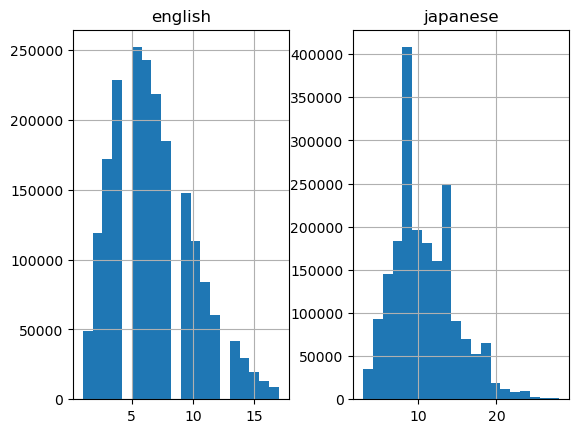

,english,japanese
0,14,22
1,14,15
2,6,11
3,8,11
4,8,11
...,...,...
1985625,8,7
1985626,7,11
1985627,6,13
1985628,5,11


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
eng_len = []
jpn_len = []

# populate the lists with sentence lengths
for i in df['eng'].to_arrow().tolist():
      eng_len.append(len(i))  
           
for i in df['jpn'].to_pandas():
      jpn_len.append(len(i))

length_df = pd.DataFrame({'english':eng_len, 'japanese':jpn_len})
length_df.hist(bins = 20)
plt.show()
length_df

# tokenization and padding

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
def get_max_value(eng_len,jpn_len):
    englength=max(eng_len)
    jpnlength=max(jpn_len)
    if(englength>=jpnlength):
        return englength
    else:
        return jpnlength
def pad_the_sentence(i,maxlen):
      if maxlen>=len(i):
            delta=maxlen-len(i)
            for x in range(delta):
                  i.append(' <eos>')
      return " ".join(i)



In [15]:
            
max_len=get_max_value(eng_len,jpn_len)
eng_col = []
jpn_col = []
# populate the lists with sentence lengths


for i in df['eng'].to_pandas():
      eng_col.append(pad_the_sentence(i,max_len))

df['eng']=eng_col
for i in df['jpn'].to_pandas():
      jpn_col.append(pad_the_sentence(i,max_len)) 
df['jpn']=jpn_col
df


,eng,jpn
0,<sos>nothing thrills me more than to see kids ...,< sos > 生徒 が お 互い の 受精 じゃ なく て 植物 の 受粉 に 熱中 し ...
1,<sos>do you want to spend all night at the cem...,< sos > この 雨 の 中 一 晩 中 墓地 に い たい questionmark ...
2,<sos>our ships are in attack position <eos> ...,< sos > 船 は もう 攻撃 発起 位置 に ある <eos> <eos> <e...
3,<sos>what about the original sam questionmark ...,< sos > オリジナル の サム が 居る ん だ ぞ <eos> <eos> <...
4,<sos>we will now begin the emergency captains ...,< sos > これ より 緊急 隊 首 会 を 行う <eos> <eos> <eo...
...,...,...
2007888,<sos>that citizens and city governments around...,< sos > 知る 必要 の ある <eos> <eos> <eos> <eos>...
2007889,<sos>what good would that have done questionma...,< sos > 知っ て 何 の 意味 が ある questionmark <eos> ...
2007890,<sos>when ichinosukesan rushed over to ninosuk...,< sos > 二 之 助 さん に 駆け寄っ た 一之助 さん は <eos> <eo...
2007891,<sos>your words are so encouraging <eos> <eo...,< sos > そう いっ た お 言葉 を 力 に <eos> <eos> <eos...


In [16]:
import numpy as np
print(f'the min values for eng is {min(eng_len)} and the min values for jpn is {max(jpn_len)}')
print(f'the max values for eng is {max(eng_len)} and the max values for jpn is {max(jpn_len)}')
print(f'the mean values for eng is {np.mean(eng_len)} and the mean values for jpn is {np.mean(jpn_len)}')

the min values for eng is 1 and the min values for jpn is 28
the max values for eng is 17 and the max values for jpn is 28
the mean values for eng is 6.626831282766679 and the mean values for jpn is 10.69807416286015


In [17]:
df=df[length_df['english']<=20]
df=df[length_df['japanese']<=20]
df

,eng,jpn
1,<sos>do you want to spend all night at the cem...,< sos > この 雨 の 中 一 晩 中 墓地 に い たい questionmark ...
2,<sos>our ships are in attack position <eos> ...,< sos > 船 は もう 攻撃 発起 位置 に ある <eos> <eos> <e...
3,<sos>what about the original sam questionmark ...,< sos > オリジナル の サム が 居る ん だ ぞ <eos> <eos> <...
4,<sos>we will now begin the emergency captains ...,< sos > これ より 緊急 隊 首 会 を 行う <eos> <eos> <eo...
5,<sos>this is an unnamed species of copepod a c...,< sos > これ は 名前 の ない カイ アシ つまり 甲殻 プランクトン です <...
...,...,...
2007888,<sos>that citizens and city governments around...,< sos > 知る 必要 の ある <eos> <eos> <eos> <eos>...
2007889,<sos>what good would that have done questionma...,< sos > 知っ て 何 の 意味 が ある questionmark <eos> ...
2007890,<sos>when ichinosukesan rushed over to ninosuk...,< sos > 二 之 助 さん に 駆け寄っ た 一之助 さん は <eos> <eo...
2007891,<sos>your words are so encouraging <eos> <eo...,< sos > そう いっ た お 言葉 を 力 に <eos> <eos> <eos...


In [18]:
#df['eng'] = df['eng'].str.join(' ')
#df['jpn'] = df['jpn'].str.join(' ')

split the data set into train val and test

In [19]:
import sklearn
df = sklearn.utils.shuffle(df)
df = df.reset_index(drop=True)  
df

,eng,jpn
0,<sos>they found someone that could do it cheap...,< sos > 後任 が 見つかっ て クビ に さ れ た <eos> <eos> ...
1,<sos>what questionmark <eos> <eos> <eos> <...,< sos > な ん だ <eos> <eos> <eos> <eos> <eo...
2,<sos>a guest <eos> <eos> <eos> <eos> <eos...,< sos > お 客 さん ん っ questionmark <eos> <eos> ...
3,<sos>so it is special <eos> <eos> <eos> <e...,< sos > それ で 特別 だ <eos> <eos> <eos> <eos> ...
4,<sos>i have the evidence <eos> <eos> <eos> ...,< sos > 《 ≪ 証拠 は 手 に 入れ てる ➡》 <eos> <eos> <...
...,...,...
1949698,<sos>and you don not mess with jackie on this ...,< sos > この 波止場 で ジャッキー 様 に 楯突く 奴 は い ない ぜ <eo...
1949699,<sos>till when will i hide it sister questionm...,< sos > お 願い いつ まで 隠し て おく の questionmark <eo...
1949700,<sos>take my hand take my hand <eos> <eos> ...,< sos > 手 を 取れ <eos> <eos> <eos> <eos> <e...
1949701,<sos>stop saying that they don t <eos> <eos>...,< sos > 俺 の 立場 に なっ て みろ <eos> <eos> <eos> ...


In [20]:
# len of train will be 1959109 values
# len of val will be 6850
# len of test will be 6756
train_data=df.iloc[13606:,:]
print(train_data.shape)
val_test_data=df.iloc[:13606,:]
valid_data=val_test_data.iloc[6850:,:]
print(valid_data.shape)
test_data=val_test_data.iloc[:6850,:]
print(test_data.shape)

(1936097, 2)
(6756, 2)
(6850, 2)


In [21]:
test_data = test_data.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)   
test_data


,eng,jpn
0,<sos>they found someone that could do it cheap...,< sos > 後任 が 見つかっ て クビ に さ れ た <eos> <eos> ...
1,<sos>what questionmark <eos> <eos> <eos> <...,< sos > な ん だ <eos> <eos> <eos> <eos> <eo...
2,<sos>a guest <eos> <eos> <eos> <eos> <eos...,< sos > お 客 さん ん っ questionmark <eos> <eos> ...
3,<sos>so it is special <eos> <eos> <eos> <e...,< sos > それ で 特別 だ <eos> <eos> <eos> <eos> ...
4,<sos>i have the evidence <eos> <eos> <eos> ...,< sos > 《 ≪ 証拠 は 手 に 入れ てる ➡》 <eos> <eos> <...
...,...,...
6845,<sos>with your life questionmark <eos> <eos>...,< sos > カンダ ー 人 の データ もっ て 事 ね <eos> <eos> ...
6846,<sos>what did you do to her questionmark <eos...,< sos > 彼女 に 何 を し た ん だ questionmark <eos> ...
6847,<sos>go ahead what are you doing <eos> <eos>...,< sos > いっ て え な 何 す ん だ よ <eos> <eos> <eos...
6848,<sos>you have a life <eos> <eos> <eos> <eo...,< sos > 自分 の 人生 よ ね <eos> <eos> <eos> <eos...


In [22]:
from datasets import Dataset, features,DatasetDict
train_data_dic={'eng':train_data['eng'].to_arrow().tolist(),"jpn":train_data['jpn'].to_arrow().tolist()}
test_data_dic={'eng':test_data['eng'].to_arrow().tolist(),"jpn":test_data['jpn'].to_arrow().tolist()}
valid_data_dic={'eng':valid_data['eng'].to_arrow().tolist(),"jpn":valid_data['jpn'].to_arrow().tolist()}
Dataset.from_dict(train_data_dic).save_to_disk("dataset_jpn_eng.hf/train")
Dataset.from_dict(test_data_dic).save_to_disk("dataset_jpn_eng.hf/test")
Dataset.from_dict(valid_data_dic).save_to_disk("dataset_jpn_eng.hf/valid")
#dataset_dic={'train':train_data_dic,"test":test_data_dic,"valid":valid_data_dic}
#dataset_dic

Saving the dataset (0/2 shards):   0%|          | 0/1936097 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6850 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6756 [00:00<?, ? examples/s]

# model


In [23]:
# import the required libraries:
import os, sys
from keras.utils import to_categorical
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.preprocessing import text
from keras.callbacks import EarlyStopping
from numpy import asarray
from datasets import Dataset
import datasets
from datasets import load_dataset
from numpy import zeros
import tensorflow as tf
import os
import torch

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import matplotlib.pyplot as plt
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')
tf.config.experimental.get_memory_growth(physical_device[0])
tf.config.experimental.set_memory_growth(physical_device[0],True)

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-19 14:34:28.369747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.372860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.372919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


###

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3721891155476576608
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11577327616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7112988384898733833
physical_device_desc: "device: 0, name: NVIDIA RTX A5000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-19 14:34:28.403586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.403947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.404036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.419051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:34:28.419197: I external/local_xla/xla/stream_executor

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
train_data = datasets.load_from_disk("dataset_jpn_eng.hf/train")
test_data = datasets.load_from_disk("dataset_jpn_eng.hf/test")
valid_data = datasets.load_from_disk("dataset_jpn_eng.hf/valid")
train_data

Dataset({
    features: ['eng', 'jpn'],
    num_rows: 1936097
})

* this was just added to make it fit
* maybe doing a Chunked Processing would work

In [26]:
list_of_empty=[]

#
for i in range(len(train_data)):
    #
    if(type(train_data[i]['eng'])==type(None) or type(train_data[i]['jpn'])==type(None)):
        #
        list_of_empty.append(i)

In [27]:
train_data = train_data.select(
    (
        i for i in range(len(train_data)) 
        if i not in set(list_of_empty)
    ))

Parameter 'indices'=<generator object <genexpr> at 0x7ff830a074c0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [28]:
EMBEDDING_SIZE=50
try:
    f = open(f'glove/glove.6B.{EMBEDDING_SIZE}d.txt', encoding='utf-8')
except FileNotFoundError:
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    raise("you need to download the file then export it then unzip it and reupload to glove")

embeddings_dictionary  = dict()
for line in f:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

Found 400000 word vectors.


In [29]:
train_data=train_data.train_test_split(test_size=0.003,seed=32)['test']

In [30]:
MAX_NUM_WORDS = 20000
input_tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(train_data['eng'])

input_integer_seq=input_tokenizer.texts_to_sequences(train_data['eng'])
#print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('\nTotal unique words in the input: %s'%len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


Total unique words in the input: 5624
Length of longest sentence in input: 29


In [31]:
encoder_input_sequences = tf.keras.utils.pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (5809, 29)
encoder_input_sequences[180]: [   2   14   11    4 2175    3  349    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1]


In [32]:
#tokenize the output sentences(Output language)
#
output_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS, filters='')
#
output_tokenizer.fit_on_texts(train_data["jpn"]+valid_data['jpn'])

#
output_integer_seq = output_tokenizer.texts_to_sequences(train_data["jpn"])
#
output_input_integer_seq = output_tokenizer.texts_to_sequences(train_data['jpn'])
#print(output_input_integer_seq)

#
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))
#
num_words_output = len(word2idx_outputs) + 1
#
max_out_len = max(len(sen) for sen in output_integer_seq)

print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)


Total unique words in the output: 11715
Length of longest sentence in the output: 28


In [33]:
decoder_input_sequences = tf.keras.utils.pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])
#print(word2idx_outputs["の"])
#print(word2idx_outputs["が"])
#print(word2idx_outputs["今"])
#print(word2idx_inputs["the"])
#print(word2idx_inputs['and'])

decoder_input_sequences.shape: (5809, 28)
decoder_input_sequences[180]: [   2    3    4   33   14 2216    5 3069   10 2217   21   13    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1]


In [34]:
#
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
#
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
#
for word, index in word2idx_inputs.items():
    #
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        #
        embedding_matrix[index] = embedding_vector
print(embeddings_dictionary["the"])

[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [35]:
#
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix])

2024-08-19 14:36:11.825203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:36:11.825352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:36:11.825378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:36:11.825594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:36:11.825605: I tensorflow/core/common_runtime/gpu/gpu

In [36]:
#
decoder_targets_one_hot = torch.zeros(
    #
    (len(train_data['eng']), max_out_len, num_words_output),
    #
    dtype=torch.float16,
    #
    device='cuda')
decoder_targets_one_hot.shape

torch.Size([5809, 28, 11716])

In [37]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

decoder_output_sequences.shape: (5809, 28)


In [38]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256

In [39]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        try:
            decoder_targets_one_hot[i, t, word] = 1
        except:
            break
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]


In [40]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [41]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [42]:
#encoder_inputs -> (max_out_len,) -> max(len(sen) for sen in output_integer_seq)

model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer="rmsprop",#'Adam',
    #CategoricalCrossentropy preforms well but, can't get out
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 29, 50)    │    281,250 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 28, 256)   │  2,999,296 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    314,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 28, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 28, 11716) │  3,011,012 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,131,238 (27.20 MB)

 Trainable params: 7,131,238 (27.20 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [43]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
print(f"encoder input shape: {encoder_input_sequences.shape} decoder input shape {decoder_input_sequences.shape} decoder target one hot shape {decoder_targets_one_hot.shape}")
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot.cpu().data.numpy(),
    batch_size=BATCH_SIZE,
    epochs=14,
    #callbacks=[es],
    validation_split=0.1
)

encoder input shape: (5809, 29) decoder input shape (5809, 28) decoder target one hot shape torch.Size([5809, 28, 11716])


: 

: 

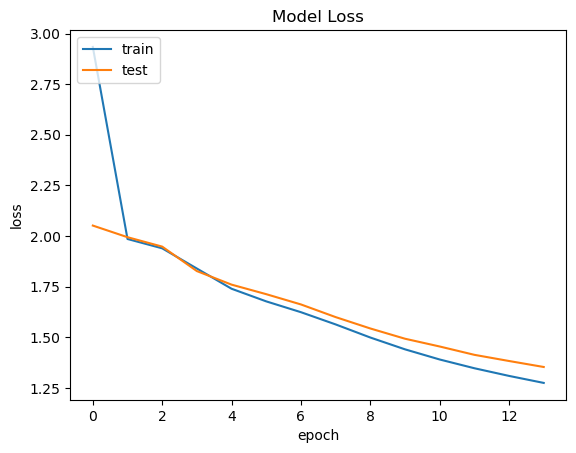

In [ ]:
model.save('seq2seq_eng-jpn.keras')
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-jpn.keras')


/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<eos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [ ]:
i = np.random.choice(len(train_data['eng']))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', train_data['eng'][i])
print('Actual translation : ', train_data['jpn'][i])
print('French translation : ', translation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Input Language :  you ll figure out a way to save em both  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>
Actual translation :  2 つ の ウィルス を 防ぐ 方法 を 考え出せる わ  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>
French translation :  


In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    
    eos = word2idx_outputs["<eos>"]
    target_seq[0, 0] = word2idx_outputs["<eos>"]
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        print(f'output token {output_tokens} h {h} c {c}')
        idx = np.argmax(output_tokens[0, 0, :])
        print(f"the index {idx}")
        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            
            print(word)
            output_sentence.append(word)

        target_seq[0, 0] = idx
        
        states_value = [h, c]
    print(output_sentence)
    return ' '.join(output_sentence)

i = np.random.choice(len(train_data['eng']))
input_seq = encoder_input_sequences[i:i+1]
#print(input_seq)
translation = translate_sentence(np.array(input_seq))
print(translation)
print('Input Language : ', train_data['eng'][i].replace(' <eos>', ''))
print('Actual translation : ', train_data['jpn'][i].replace(' <eos>', ''))
print('japanese translation : ', translation.replace(' <eos>', ''))
#~

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
output token [[[6.5204486e-09 9.8166060e-01 1.1938941e-12 ... 5.9545706e-09
   5.5772356e-09 6.2526322e-09]]] h [[ 0.8681065  -0.99593014  0.97607565 -0.96732646  0.9459243  -0.96978724
   0.8808548  -0.8332239   0.6975851  -0.98756355  0.9922315   0.99779505
   0.8452051  -0.7781461  -0.9503466   0.97795796  0.97434807 -0.96760815
   0.93346435 -0.75742424 -0.95958173 -0.97265536 -0.98097336  0.9850526
  -0.9730412   0.56387097 -0.9648179   0.9635805  -0.9755307  -0.9557893
  -0.97767574 -0.8123845  -0.9826601  -0.9952677  -0.9564586   0.74809116
  -0.8916091  -0.98055035 -0.93391705 -0.9912324   0.9756926   0.9932177
   0.9668309  -0.9844017   0.970612   -0.9801785   0.9700546  -0.9772632
  -0.9392921   0.92563826 -0.98267204  0.97664106  0.9832507   0.98175067
   0.96255386 -0.9756411   0.98212963  0.97781223  0.894677   -0.9793843
   0.92615795  0.9990207   0.72659355  0.89564836 -0.66506666 -0.97071075
  -

# working model

In [ ]:
# import the required libraries:
import os, sys
from keras.utils import to_categorical
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.preprocessing import text
from keras.callbacks import EarlyStopping
from numpy import asarray
from datasets import Dataset
import datasets
from datasets import load_dataset
from numpy import zeros
import tensorflow as tf
import os
import torch

#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import matplotlib.pyplot as plt
#physical_device = tf.config.experimental.list_physical_devices('GPU')
#print(f'Device found : {physical_device}')
#tf.config.experimental.get_memory_growth(physical_device[0])
#tf.config.experimental.set_memory_growth(physical_device[0],True)

In [ ]:
train_data = datasets.load_from_disk("dataset_jpn_eng.hf/train")
test_data = datasets.load_from_disk("dataset_jpn_eng.hf/test")
valid_data = datasets.load_from_disk("dataset_jpn_eng.hf/valid")
train_data

Dataset({
    features: ['eng', 'jpn'],
    num_rows: 1961695
})

In [ ]:
train_data=train_data.train_test_split(test_size=0.003,seed=32)['test']

In [ ]:

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(f'glove/glove.6B.{EMBEDDING_SIZE}d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()


In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
print(embeddings_dictionary["join"])


[ 0.35819   0.27701   0.11172  -0.2323    0.088961 -0.38405  -0.90414
  0.8364   -0.57683  -0.53735   0.39809   0.22029  -0.45777   0.23434
 -0.11633   0.30078   0.81404  -0.1125   -0.045471 -0.23455   0.041953
  0.011856 -0.10295   0.63302  -0.41546  -1.5055    0.76489  -0.95373
 -0.85943  -0.42165   2.6321    1.2754   -1.3012   -0.12969  -0.23035
 -0.48685  -0.1713   -0.28975  -0.56311  -0.61723  -0.077356 -0.37792
 -0.047039 -0.59064   0.19568   0.17748  -0.51369  -0.02406  -0.86568
 -0.10985 ]


In [ ]:
print(embedding_matrix[464])


[ 0.26672    -0.20723     0.071057   -1.07149994  1.1178      0.48903999
 -0.45592001  0.51819998 -0.87917     0.31479001 -0.063093    0.71833998
 -1.0115      0.069413    0.30610001 -0.035464    0.13265     0.013419
 -0.065832   -0.035541   -0.042574    0.72447997  0.27434    -0.14834
  0.68945998 -2.48090005 -0.30622    -0.074942    0.045173   -0.41012001
  2.28780007 -0.26370001 -0.50743002 -0.65030998 -0.15885     0.36169001
  0.17234001  0.90324003 -0.4235     -0.44363001  0.2119      0.46470001
 -0.86723     0.037213   -0.086144   -0.31825    -0.53223002 -1.03489995
  0.093597   -0.19408999]


In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


In [ ]:
decoder_targets_one_hot = np.zeros((
        len(train_data['eng']),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape


(5886, 25, 11867)

In [ ]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1


In [ ]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]


In [ ]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)


In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 25, 50)    │    283,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 25, 256)   │  3,037,952 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    314,368 │ embedding_5[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 25, 256), │    525,312 │ embedding_6[0][0… │
│                     │ (None, 256),      │            │ lstm_4[0][1],     │
│                     │ (None, 256)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25, 11867) │  3,049,819 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,210,851 (27.51 MB)

 Trainable params: 7,210,851 (27.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.6571 - loss: 4.4083 - val_accuracy: 0.7055 - val_loss: 2.0440
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7066 - loss: 2.0068 - val_accuracy: 0.7097 - val_loss: 1.9907
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7120 - loss: 1.9528 - val_accuracy: 0.7102 - val_loss: 1.9676
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7219 - loss: 1.8786 - val_accuracy: 0.7202 - val_loss: 1.8438
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7217 - loss: 1.7782 - val_accuracy: 0.7216 - val_loss: 1.7694
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7282 - loss: 1.6767 - val_accuracy: 0.7309 - val_loss: 1.7207
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7354 - loss: 1.6336 - val_accuracy: 0.7483 - val_loss: 1.6702
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7535 - loss: 1.5857 - val_accuracy: 0.7694 - v

In [ ]:
model.save('seq2seq_eng-fra.h5')

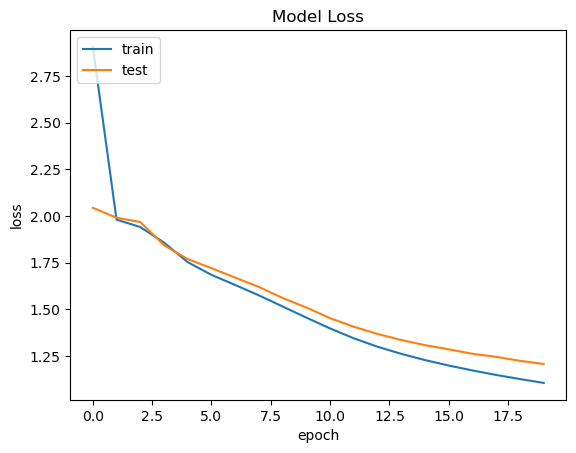

In [ ]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h5')


In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}


In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<eos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [ ]:
i = np.random.choice(len(train_data['eng']))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', train_data['eng'][i])
print('Actual translation : ', train_data['jpn'][i])
print('French translation : ', translation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Input Language :  of inviting the television program 60 minutes ii into their house  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>
Actual translation :  家 に 招待 し て マーラ が 絵 を 描く ところ を 撮影 さ せる と いう  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>  <eos>
French translation :  
